# Notebook to visualise output from large training routines carried out on fields

In [2]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from plot import *
from utils import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams.update({'font.size': 18})

In [3]:
# useful to define the model structures we will be using here
 ### Define the different hLN architectures we will be using:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = np.array([0])
# 2N
Jc_2n = np.array([0, 1, 1])
# 3N
Jc_3n = np.array([0, 1, 1, 2, 2, 3, 3])
# 4N
Jc_4n = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

# list of lists for to define hierarchical clustering
clusts = [[[[[0, 1], [2]], [[3, 4], [5, 6]]], [[[7, 8], [9]], [[10, 11], [12]]]]]

Wce_1l, Wci_1l = create_weights(Jc_1l, n_levels=1, clusts=clusts)
Wce_2n, Wci_2n = create_weights(Jc_2n, n_levels=2, clusts=clusts)
Wce_3n, Wci_3n = create_weights(Jc_3n, n_levels=3, clusts=clusts)
Wce_4n, Wci_4n = create_weights(Jc_4n, n_levels=4, clusts=clusts)

In [5]:
loaded = np.load('/tmp/training_data.npz', allow_pickle=True)

In [6]:
train_accs, test_accs, trained_plist, target_plist = loaded['a'], loaded['b'], loaded['c'], loaded['d']

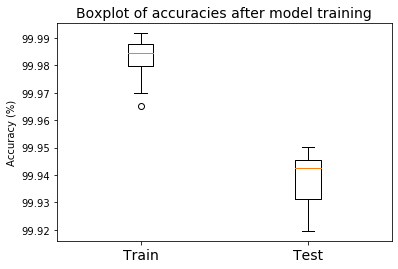

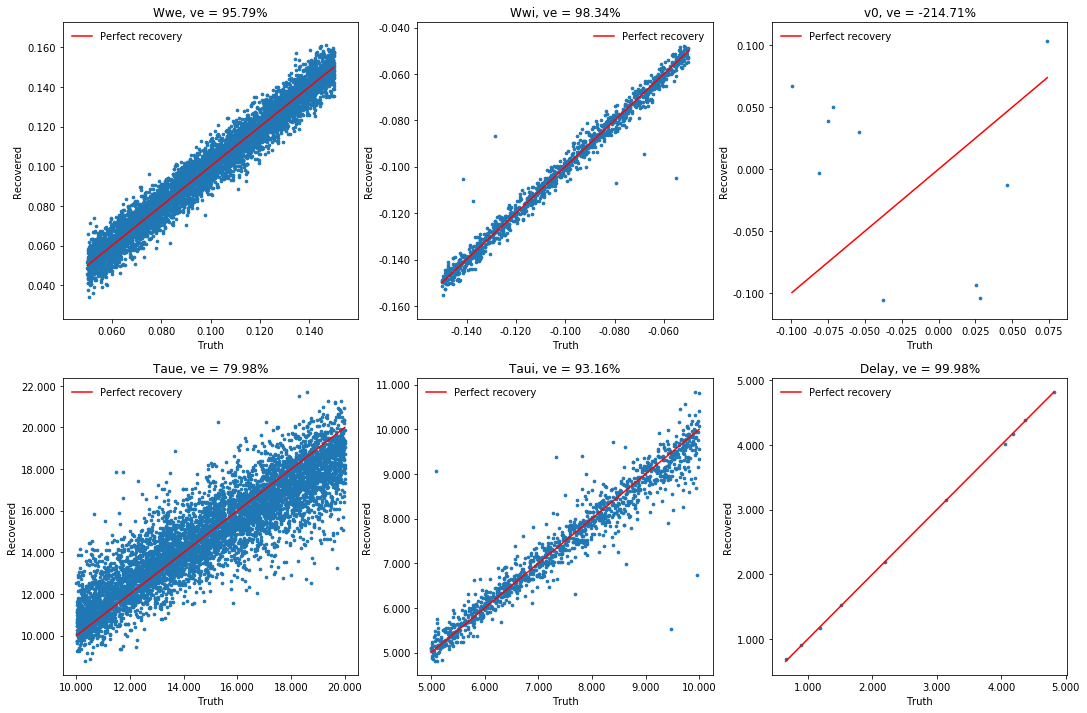

In [7]:
box_accuracies(accuracies=[train_accs, test_accs], labels=['Train', 'Test'])
plot_params_1li(trained_plist, target_plist)

In [154]:
loaded_models = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/val_tied_1lt.npz', allow_pickle=True)

In [155]:
target_params_list, trained_params_list, inputs = loaded_models['a'], loaded_models['b'], loaded_models['c']

In [156]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [157]:
# reload parameters, create models with them and extract accuracy metrics

train_accs_list_valtiedt=[]
test_accs_list_valtiedt=[]

for j in range(len(target_params_list)):
    params_1l = trained_params_list[j][0]
    params_1n = trained_params_list[j][1]
    params_2n = trained_params_list[j][2]
    params_3n = trained_params_list[j][3]
    params_4n = trained_params_list[j][4]

    hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
    for i in range(len(hln_1l.params)):
        hln_1l.params[i].assign(params_1l[i])

    hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
    for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])

    hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
    for i in range(len(hln_2n.params)):
        hln_2n.params[i].assign(params_2n[i])

    hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True,
                                                                             True, True, True, True]))
    for i in range(len(hln_3n.params)):
        hln_3n.params[i].assign(params_3n[i])

    hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                             True, True, True, True, True, True, True,
                                                                             True]))
    for i in range(len(hln_4n.params)):
        hln_4n.params[i].assign(params_4n[i])

    target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

    for i in range(len(target_model.params)):
        target_model.params[i].assign(target_params_list[j][i])
        
        
    # generate target traces 
    train_target = target_model(train_inputs)
    val_target = target_model(val_inputs)
    test_target = target_model(test_inputs)    
        
        
    # evaluate models on test data:
    train_accs, test_accs = [], []
    models=[hln_1l, hln_1n, hln_2n, hln_3n, hln_4n]
    for model in models:
        train_out, test_out = model(train_inputs), model(test_inputs)
        train_acc = 100 * (1-loss(train_out, train_target)/np.var(train_target))
        test_acc = 100 * (1-loss(test_out, test_target)/np.var(test_target))
        train_accs.append([train_acc.numpy()])
        test_accs.append(test_acc.numpy())

    train_accs_list_valtiedt.append(train_accs)
    test_accs_list_valtiedt.append(test_accs)

In [112]:
model = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
logTaues = []
logTauis = []
Wwes = []
Wwis = []
for m in range(len(model.Jc)):
    logTaues = tf.concat((logTaues, tf.fill(dims=[len(model.Wce[m])], value=model.logTaue[m])), axis=0)
    logTauis = tf.concat((logTauis, tf.fill(dims=[len(model.Wci[m])], value=model.logTaui[m])), axis=0)
    Wwes = tf.concat((Wwes, tf.fill(dims=[len(model.Wce[m])], value=model.Wwe[m])), axis=0)
    Wwis = tf.concat((Wwis, tf.fill(dims=[len(model.Wci[m])], value=model.Wwi[m])), axis=0)

In [116]:
logTauis

<tf.Tensor: shape=(749,), dtype=float32, numpy=
array([2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
       2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984, 2.4496984,
   

In [92]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list), a_min=0, a_max=None))

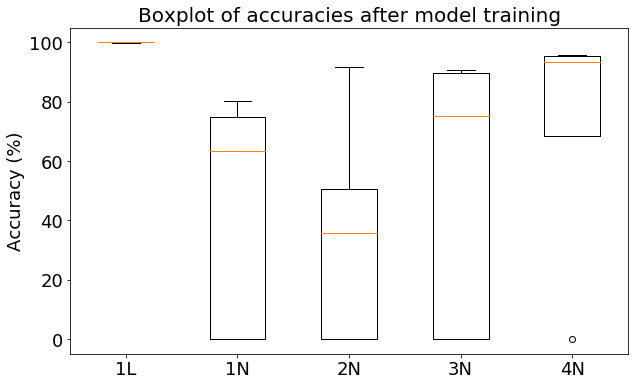

In [130]:
train_accs = np.array(train_accs, ndmin=2)
test_accs = np.array(test_accs, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])


<tf.Tensor: shape=(1,), dtype=bool, numpy=array([False])>

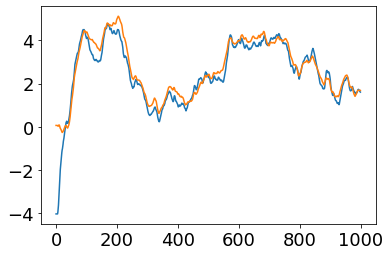

In [104]:
plt.plot(hln_4n(val_inputs).numpy().T[:1000], label='1L attempt')
plt.plot(val_target.numpy().T[:1000], label='Target')
target_model.sig_on

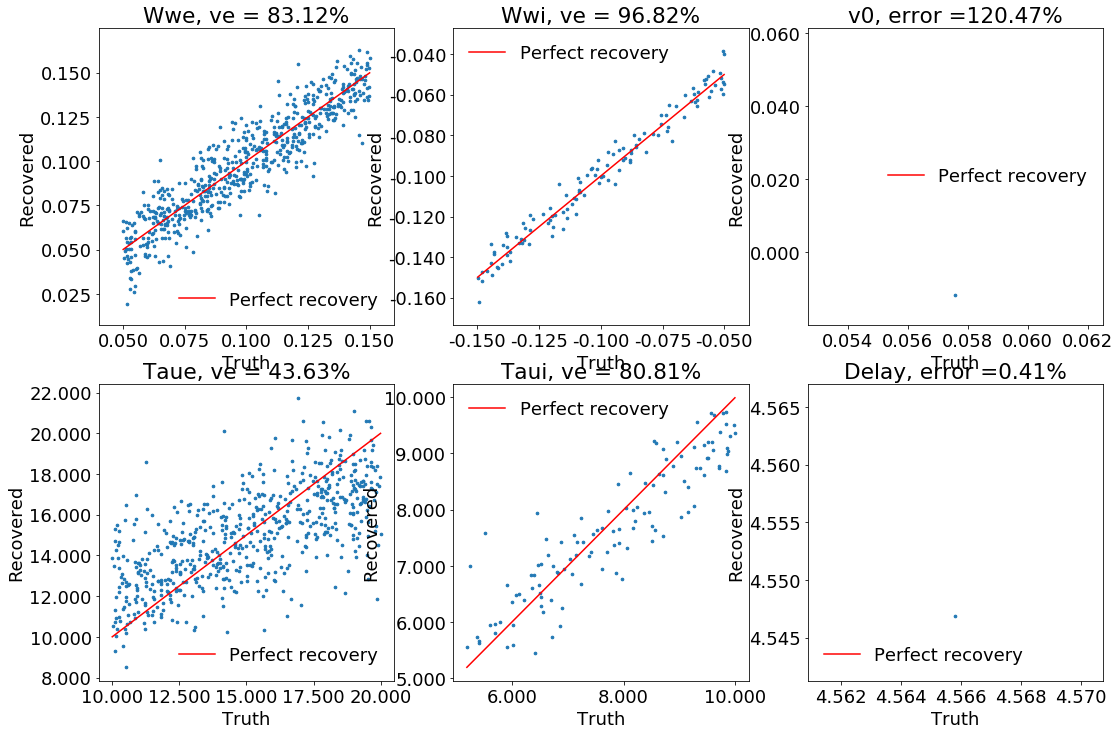

In [117]:
plot_params_1li(trained_params=[params_1l], target_params=[target_params_list[4]])

## Now take trained 1L model and initialise and train each complex model in turn: where are we going wrong?

In [128]:
trained_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])
attempt_1l = trained_1l(train_inputs)
acc_1l= 100*(1-(loss(train_target, attempt_1l)/np.var(train_target)))
print(acc_1l)

tf.Tensor(96.95021, shape=(), dtype=float32)


In [125]:
# now initialise 1n model and train for certain number of epochs
untrained_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
init_nonlin(X=train_inputs, model=untrained_1n, lin_model=trained_1l, nSD=50)
attempt_1n = untrained_1n(train_inputs)
acc_1n = 100*(1-(loss(train_target, attempt_1n)/np.var(train_target)))
print(acc_1n)

tf.Tensor(95.15826, shape=(), dtype=float32)


In [136]:
train_accs_arr_1l3 = np.squeeze(np.clip(np.array(train_accs_list_1l3), a_min=0, a_max=None))
test_accs_arr_1l3 = np.squeeze(np.clip(np.array(test_accs_list_1l3), a_min=0, a_max=None))

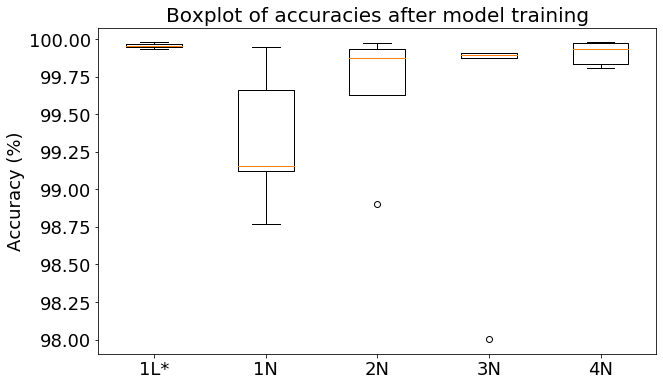

In [184]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_1l3)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

In [143]:
train_accs_arr_3n = np.squeeze(np.clip(np.array(train_accs_list_3n), a_min=0, a_max=None))
test_accs_arr_3n = np.squeeze(np.clip(np.array(test_accs_list_3n), a_min=0, a_max=None))

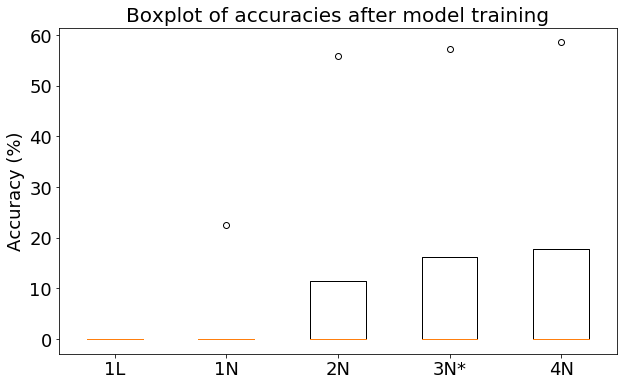

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n)
ax.set_xticklabels(['1L', '1N', '2N', '3N*', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

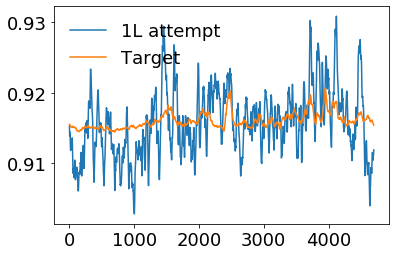

In [163]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()
# target_model.sig_on

In [168]:
train_accs_arr_3n2 = np.squeeze(np.clip(np.array(train_accs_list_3n2), a_min=0, a_max=None))
test_accs_arr_3n2 = np.squeeze(np.clip(np.array(test_accs_list_3n2), a_min=0, a_max=None))

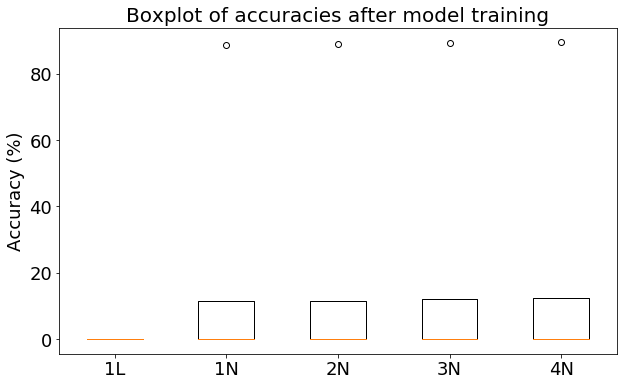

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n2)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

In [173]:
train_accs_arr_3n2

array([[ 0.      , 11.427223, 11.554128, 12.132227, 12.34796 ],
       [ 0.      , 88.679436, 88.99115 , 89.41328 , 89.494385],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],
      dtype=float32)

In [174]:
test_accs_arr_3n2

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , 77.49548, 78.25777, 79.04724, 78.83434],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]], dtype=float32)

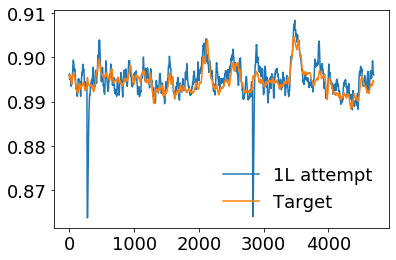

In [182]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()

## Clear problem with Adam optimizer for >1L models and 1L target - training accuracy should not go down when we step up a model. Next run some experiments with Amsgrad variant to try and solve

In [191]:
train_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(train_accs_list_amsgrad_1l), a_min=0, a_max=None))
test_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(test_accs_list_amsgrad_1l), a_min=0, a_max=None))

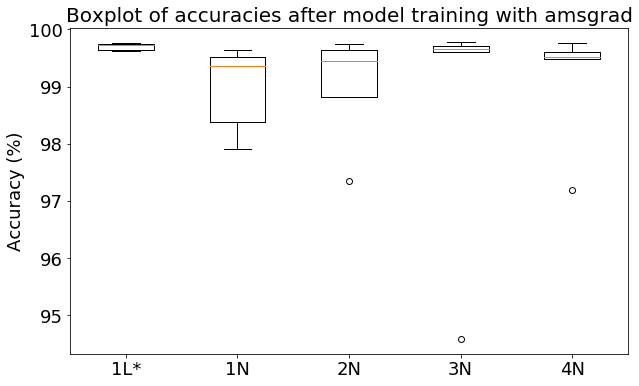

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training with amsgrad', fontsize=20)
ax.boxplot(test_accs_arr_amsgrad_1l)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

In [203]:
train_accs_arr_amsgrad_1l_long = np.squeeze(np.clip(np.array(train_accs_list_amsgrad_1l_long), a_min=0, a_max=None))
test_accs_arr_amsgrad_1l_long = np.squeeze(np.clip(np.array(test_accs_list_amsgrad_1l_long), a_min=0, a_max=None))

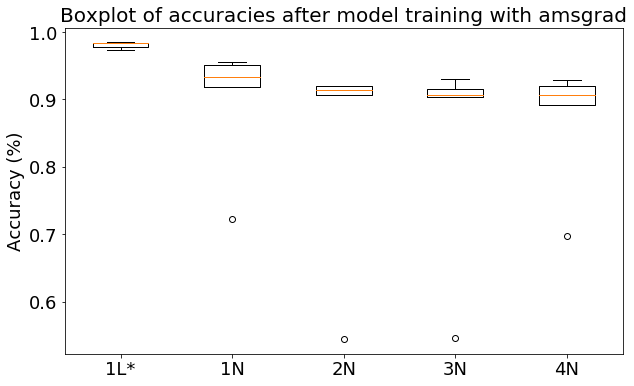

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training with amsgrad', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
ax.boxplot(1-np.sqrt(1-train_accs_arr_amsgrad_1l_long/100))
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

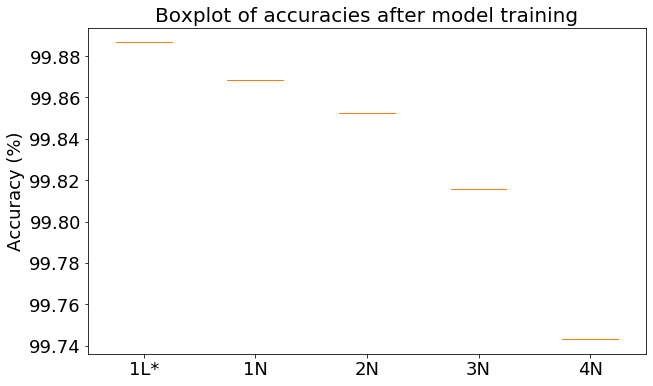

In [469]:
# nsds varied, best result chosen
train_accs = np.squeeze(np.clip(np.array(train_accs_list_nsds_1l), a_min=0, a_max=None))
test_accs = np.squeeze(np.clip(np.array(test_accs_list_nsds_1l), a_min=0, a_max=None))

train_accs = np.array(train_accs, ndmin=2)
test_accs = np.array(test_accs, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(test_accs)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()



# Now look at results from debug_training function - returns accuracy over whole training and validation sets

In [500]:
loaded_debug = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/debug_1l2.npz', allow_pickle=True)

In [501]:
target_params, trained_params, inputs, train_losses, val_losses = loaded_debug['a'], loaded_debug['b'], loaded_debug['c'], loaded_debug['d'], loaded_debug['e']


In [502]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [503]:
train_losses_1l, train_losses_1n, train_losses_2n,train_losses_3n, train_losses_4n = [loss for loss in train_losses]

In [504]:
val_losses_1l, val_losses_1n, val_losses_2n, val_losses_3n, val_losses_4n = [loss for loss in val_losses]

In [505]:
# reproduce target model in order to get accuracies
target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
# target_model=hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))

for i in range(len(target_model.params)):
    target_model.params[i].assign(target_params[i])
    
train_target = target_model(train_inputs)
train_var = np.var(train_target)
val_target = target_model(val_inputs)
val_var = np.var(val_target)

In [506]:
def get_accs(losses, target_variance):
    """function to get accuracy from an array of losses, using the variance of the target trace"""

    accs = 100 * (1 - losses/target_variance)

    return accs

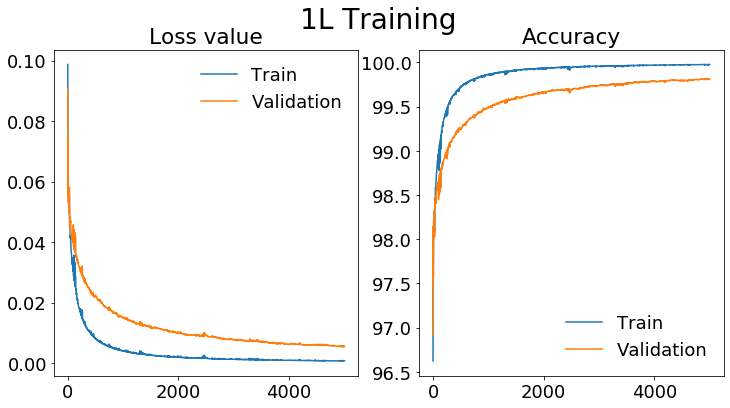

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

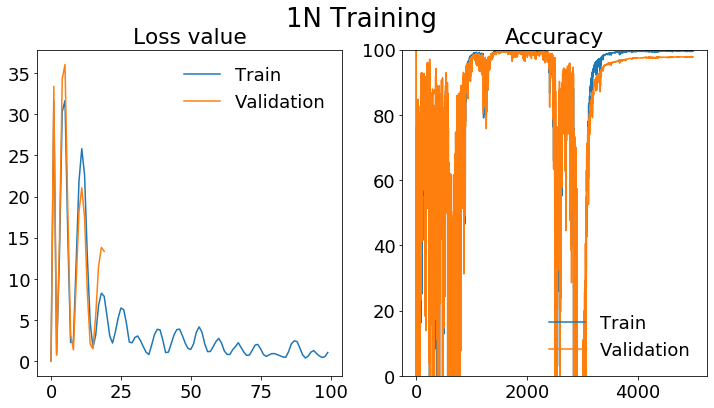

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n[:100], label='Train')
ax[0].plot(val_losses_1n[:20], label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("1N Training", fontsize=26)
plt.show()

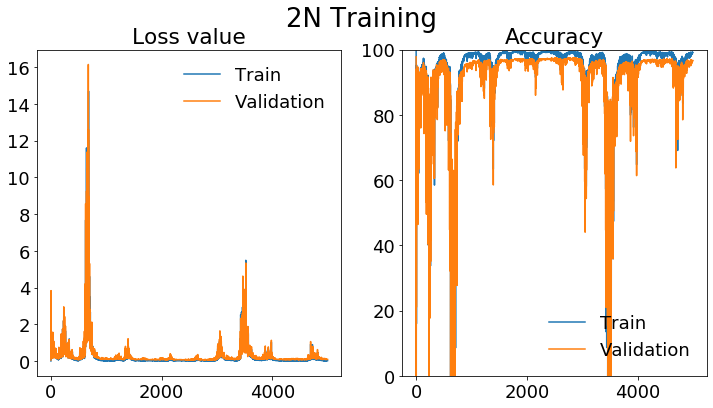

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

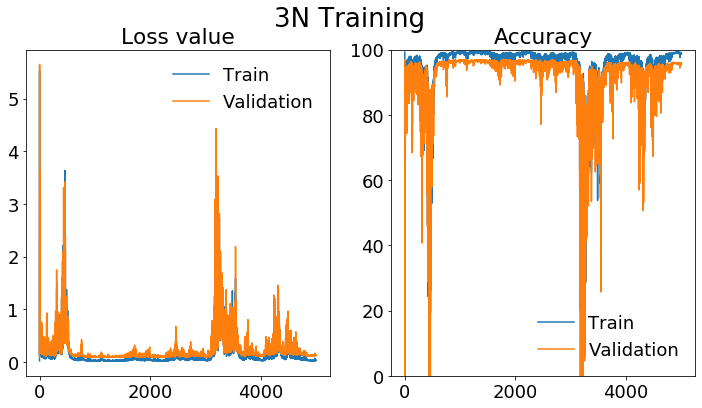

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

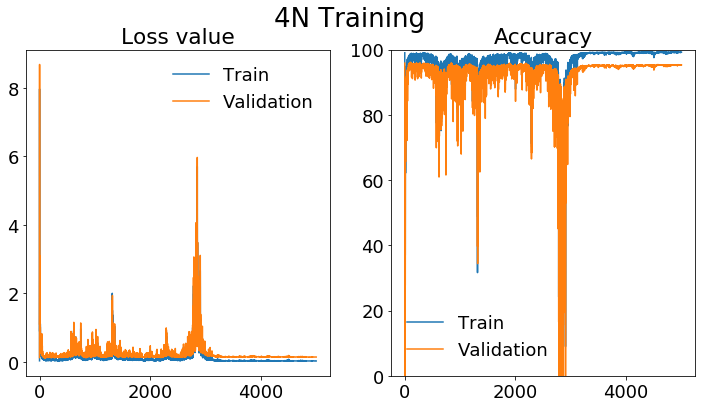

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

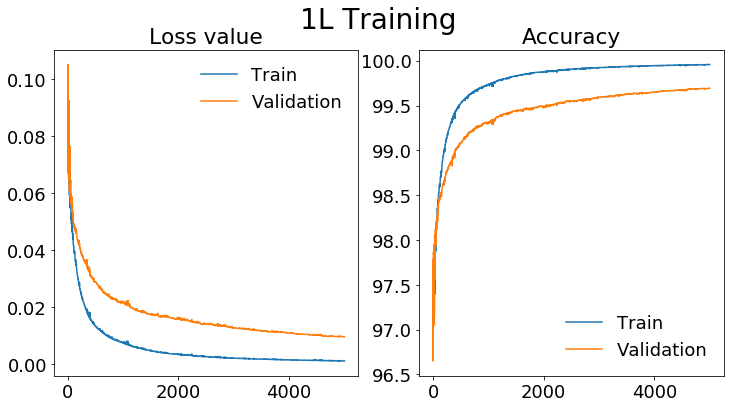

In [507]:
# now lets have a look with smaller nSD=4
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

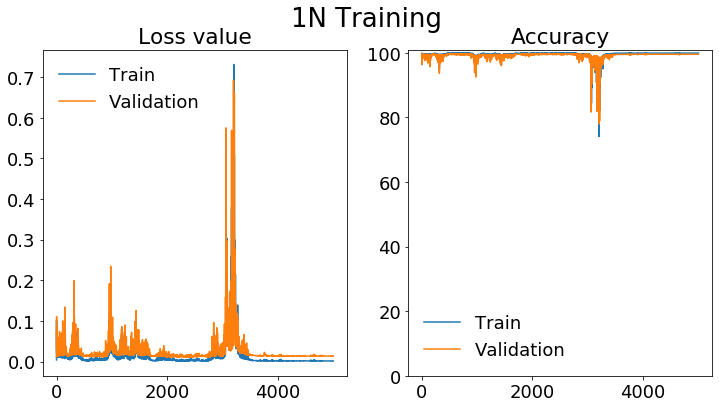

In [508]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,101)

fig.suptitle("1N Training", fontsize=26)
plt.show()

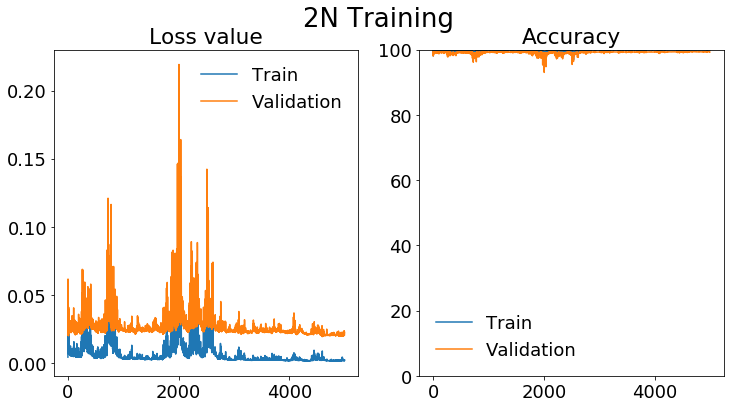

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

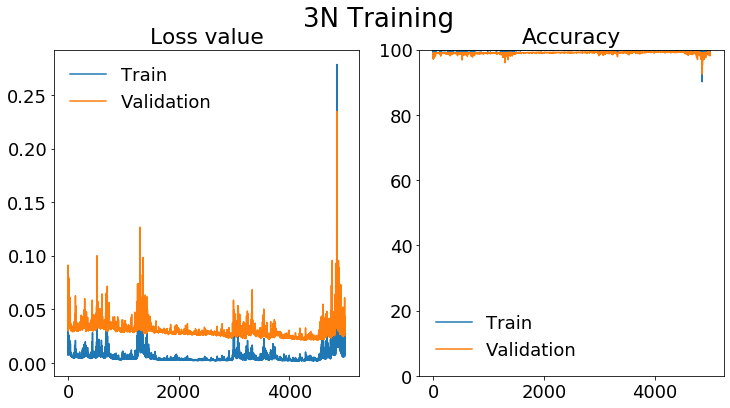

In [279]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

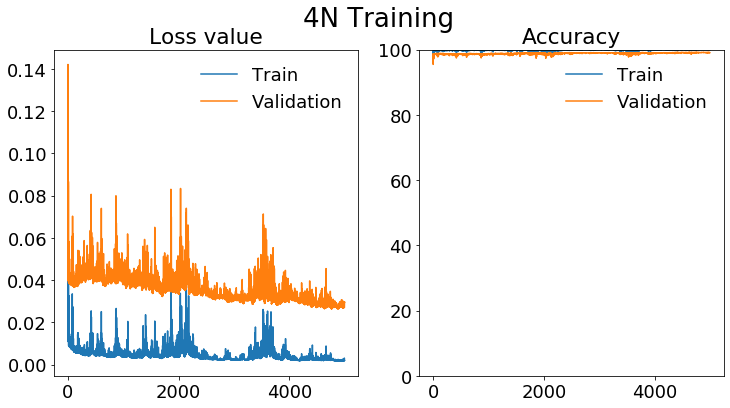

In [280]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

## now lets have a look with smaller nSD yet again, nSD=1

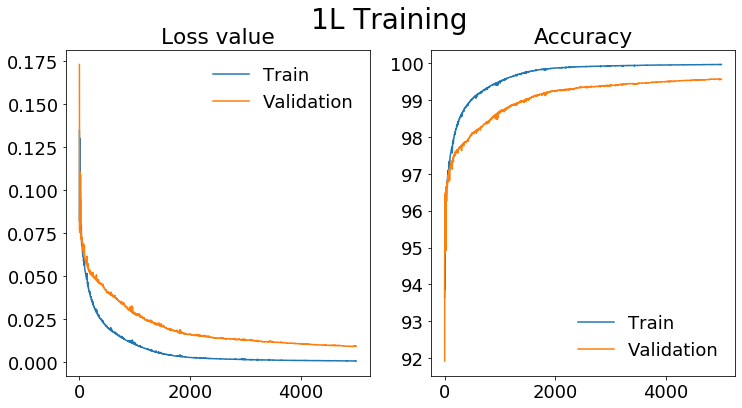

99.96067

In [487]:

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

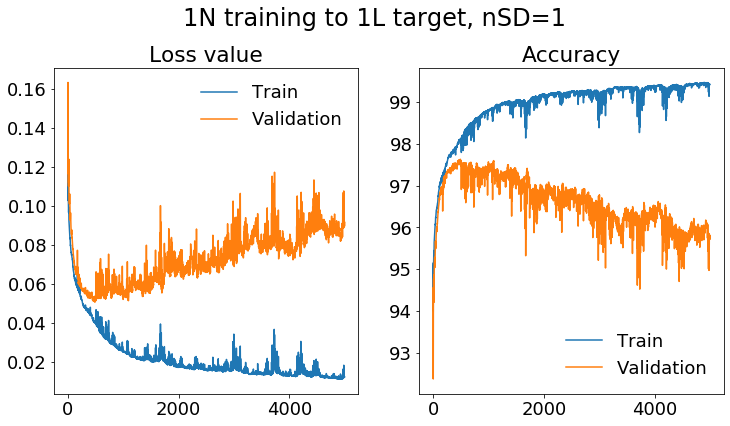

In [499]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,101)

fig.suptitle("1N training to 1L target, nSD=1 ", fontsize=24, y=1.02)
plt.show()

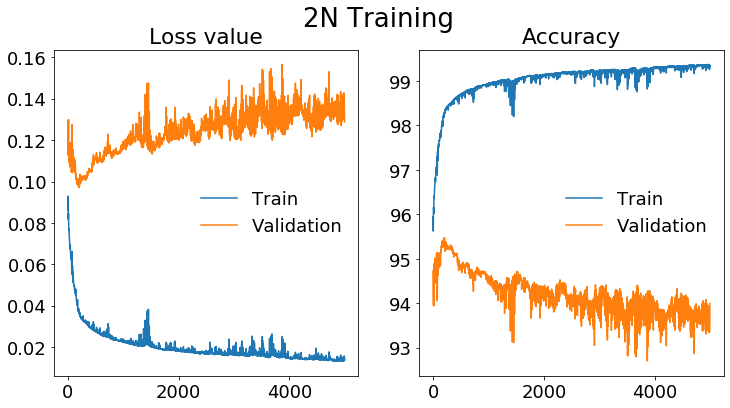

In [454]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

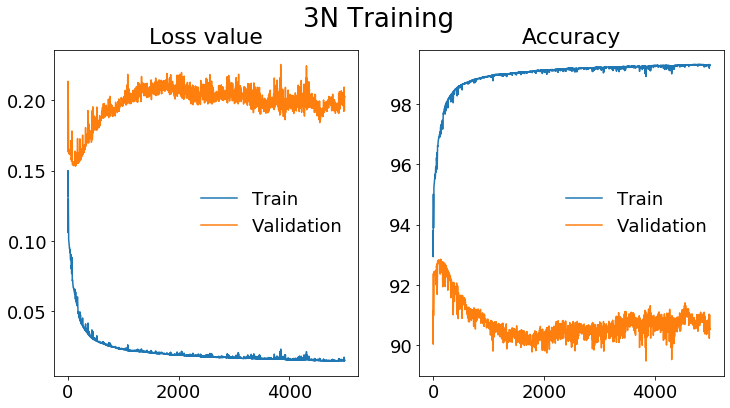

In [455]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

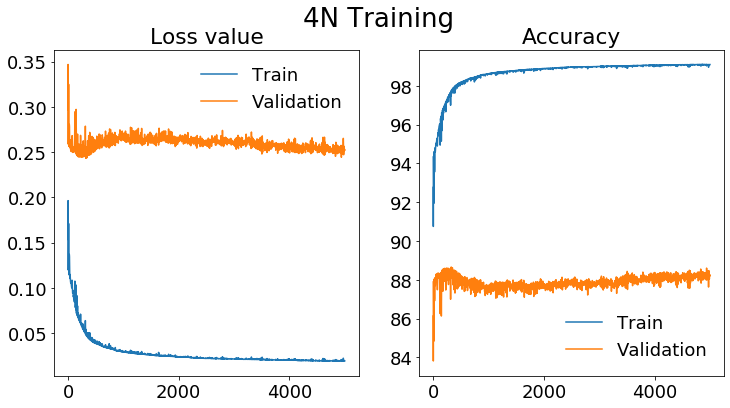

In [456]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

# Also need to find good training procedure for 1L model for complex targets - do we need to tie parameters? Ideally not, experiments here

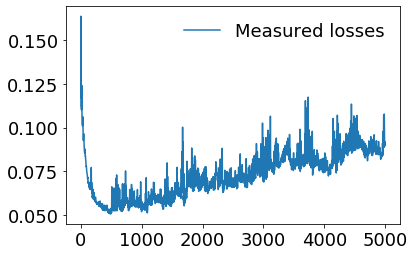

In [373]:
# First we need reliable train_until function - stop training when validation set improvement stagnates, but need to 
# be careful of noisy validation loss due to batch training - try a moving average
val_losses_4n
mas = np.zeros(len(val_losses_1n))
mas[0]=val_losses_1n[0]
alpha=0.99
for i in range(1, len(mas)):
    mas[i] = (alpha * mas[i-1] + (1 - alpha) * val_losses_1n[i])
    
    
plt.plot(val_losses_1n, label="Measured losses")
# plt.plot(mas, label="Moving average")
plt.legend()
plt.show()

### try with 2N target - according to Ujfalussy we should be able to achieve ~75% accuracy with the 1L model

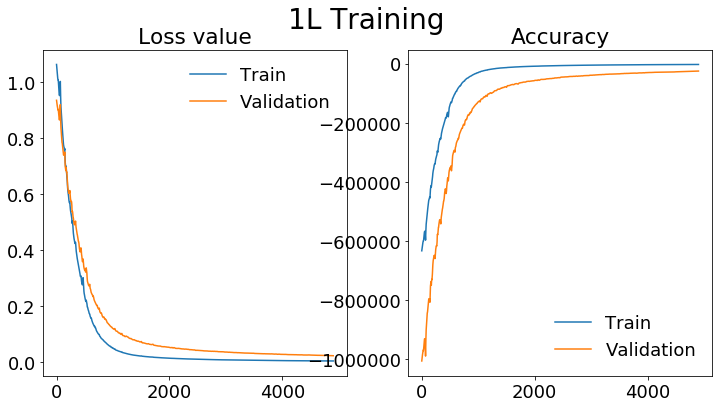

In [317]:
# now lets have a look with smaller nSD yet again, nSD=1
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l[100:], label='Train')
ax[0].plot(val_losses_1l[100:], label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l[100:], train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l[100:], val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(bottom=-10000)

fig.suptitle("1L Training", fontsize=28)
plt.show()

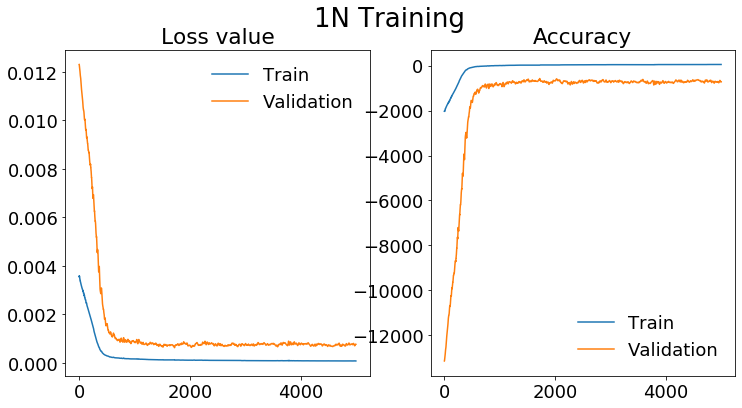

In [308]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,101)

fig.suptitle("1N Training", fontsize=26)
plt.show()

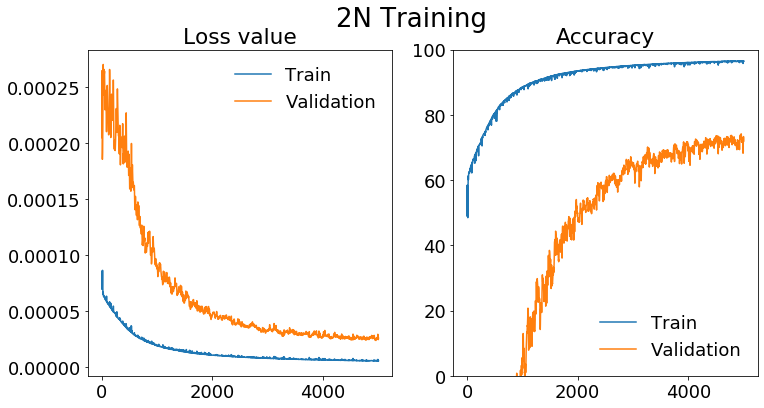

In [309]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

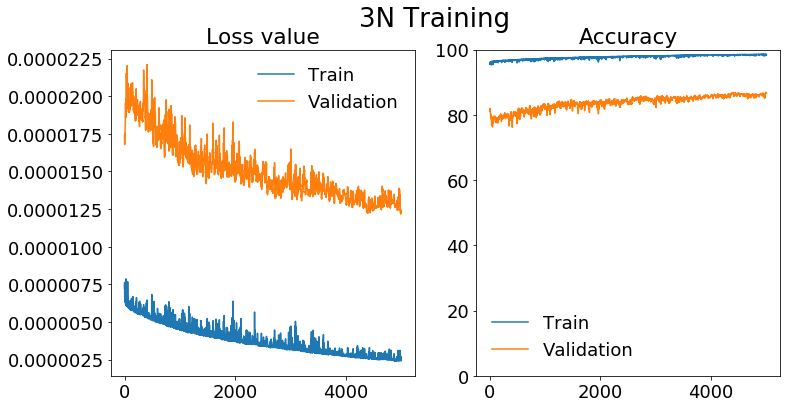

In [310]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

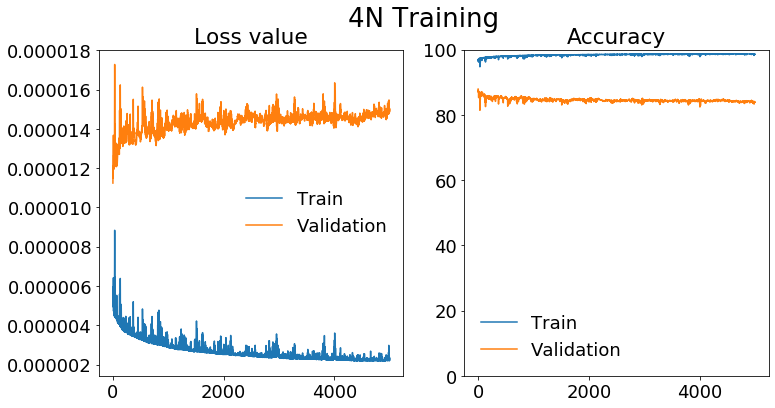

In [311]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

In [419]:
tied = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                                              epsilon=1e-07, amsgrad=True)
ls, accs = train_sgd(tied, 5, optimizer_adam, train_inputs, train_target_2n)

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


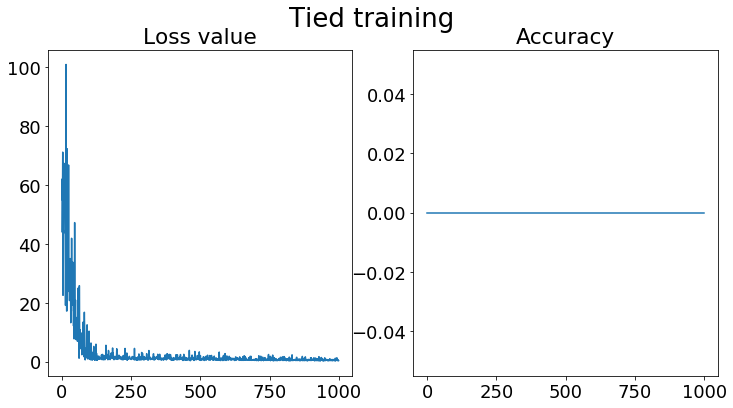

In [410]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(ls)
ax[0].set_title("Loss value")

ax[1].plot(accs)
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("Tied training", fontsize=26)
plt.show()

In [408]:
target_model_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
train_target_2n=target_model_2n(train_inputs)

## Compare tied function finished - results below

In [410]:
compare_tied_results = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/comp_tied_2n2.npz', allow_pickle=True)

In [411]:
tied_train_accuracies, tied_test_accuracies, untied_train_accuracies, untied_test_accuracies = compare_tied_results['a'], compare_tied_results['b'], compare_tied_results['c'], compare_tied_results['d']

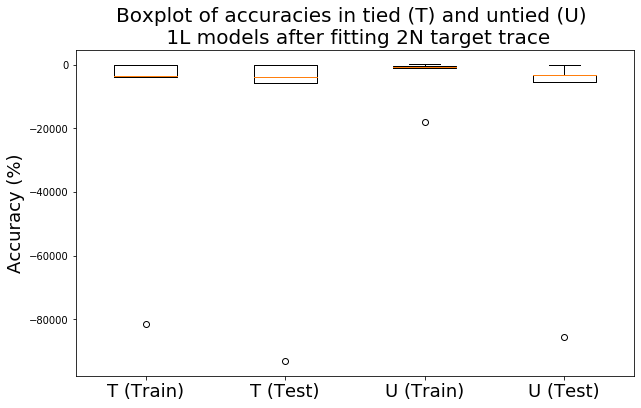

In [414]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies in tied (T) and untied (U) \n 1L models after fitting 2N target trace', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
# ax.boxplot([tied_train_accuracies, tied_test_accuracies, untied_train_accuracies, untied_test_accuracies])
ax.boxplot([clip(tied_train_accuracies), clip(tied_test_accuracies), clip(untied_train_accuracies), clip(untied_test_accuracies)])
ax.set_xticklabels(['T (Train)', 'T (Test)', 'U (Train)', 'U (Test)'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(-3000, 100)

plt.show()

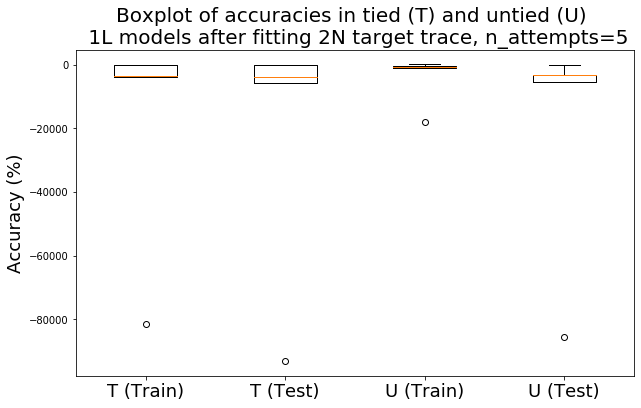

In [413]:
clip = lambda a : np.clip(a, a_min=None, a_max=1000)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies in tied (T) and untied (U) \n 1L models after fitting 2N target trace, n_attempts=5', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
ax.boxplot([clip(tied_train_accuracies), clip(tied_test_accuracies), clip(untied_train_accuracies), clip(untied_test_accuracies)])
ax.set_xticklabels(['T (Train)', 'T (Test)', 'U (Train)', 'U (Test)'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(0, 100)

plt.show()

## Wrote new initialisation procedure for tied models - test here

In [52]:
hln_1l = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

target=hln_1l(inputs)

hln_1n = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
init_nonlin_tied(X=inputs, model=hln_1n, lin_model=hln_1l, nSD=40)
attempt_1n = hln_1n(inputs)
acc_1n = 100*(1-(loss(target, attempt_1n)/np.var(target)))
print(acc_1n)

hln_2l = hLN_TiedModel(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, False, False]))
update_arch_tied(prev_model=hln_1n, next_model=hln_2l)
attempt_2l = hln_2l(inputs)
acc_2l = 100*(1-(loss(target, attempt_2l)/np.var(target)))
print(acc_2l)

hln_2n = hLN_TiedModel(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
init_nonlin_tied(X=inputs, model=hln_2n, lin_model=hln_2l, nSD=40)
attempt_2n = hln_2n(inputs)
acc_2n = 100*(1-(loss(target, attempt_2n)/np.var(target)))
print(acc_2n)

hln_3l = hLN_TiedModel(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, False, False, False, False]))
update_arch_tied(prev_model=hln_2n, next_model=hln_3l)
attempt_3l = hln_3l(inputs)
acc_3l = 100*(1-(loss(target, attempt_3l)/np.var(target)))
print(acc_3l)

hln_3n = hLN_TiedModel(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, True, True, True, True]))
init_nonlin_tied(X=inputs, model=hln_3n, lin_model=hln_3l, nSD=40)
attempt_3n = hln_3n(inputs)
acc_3n = 100*(1-(loss(target, attempt_3n)/np.var(target)))
print(acc_3n)

hln_4l = hLN_TiedModel(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True, 
                                                         False, False, False, False, False, False, False, False]))
update_arch_tied(prev_model=hln_3n, next_model=hln_4l)
attempt_4l = hln_4l(inputs)
acc_4l = 100*(1-(loss(target, attempt_4l)/np.var(target)))
print(acc_4l)

hln_4n = hLN_TiedModel(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                     True, True, True, True, True, True, True, True]))
init_nonlin_tied(X=inputs, model=hln_4n, lin_model=hln_4l, nSD=40)
attempt_4n = hln_4n(inputs)
acc_4n = 100*(1-(loss(target, attempt_4n)/np.var(target)))
print(acc_4n)

tf.Tensor(99.99999, shape=(), dtype=float32)
tf.Tensor(99.99999, shape=(), dtype=float32)
tf.Tensor(99.99996, shape=(), dtype=float32)
tf.Tensor(99.99996, shape=(), dtype=float32)
tf.Tensor(99.99991, shape=(), dtype=float32)
tf.Tensor(99.99991, shape=(), dtype=float32)
tf.Tensor(99.99976, shape=(), dtype=float32)


In [53]:
loaded_debug = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/debug_tied_1l.npz', allow_pickle=True)

target_params, trained_params, inputs, train_losses, val_losses = loaded_debug['a'], loaded_debug['b'], loaded_debug['c'], loaded_debug['d'], loaded_debug['e']


In [54]:
train_losses_1l, train_losses_1n, train_losses_2n,train_losses_3n, train_losses_4n = [loss for loss in train_losses]

val_losses_1l, val_losses_1n, val_losses_2n, val_losses_3n, val_losses_4n = [loss for loss in val_losses]

In [56]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

# reproduce target model in order to get accuracies
target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
# target_model=hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))

for i in range(len(target_model.params)):
    target_model.params[i].assign(target_params[i])
    
train_target = target_model(train_inputs)
train_var = np.var(train_target)
val_target = target_model(val_inputs)
val_var = np.var(val_target)

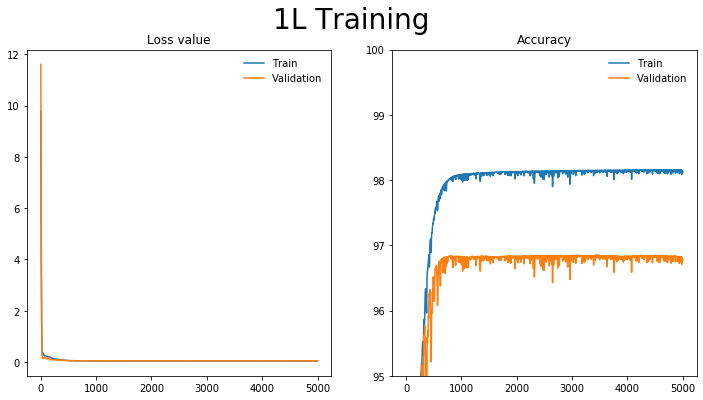

In [64]:

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_target), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_target), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(95, 100)

fig.suptitle("1L Training", fontsize=28)
plt.show()

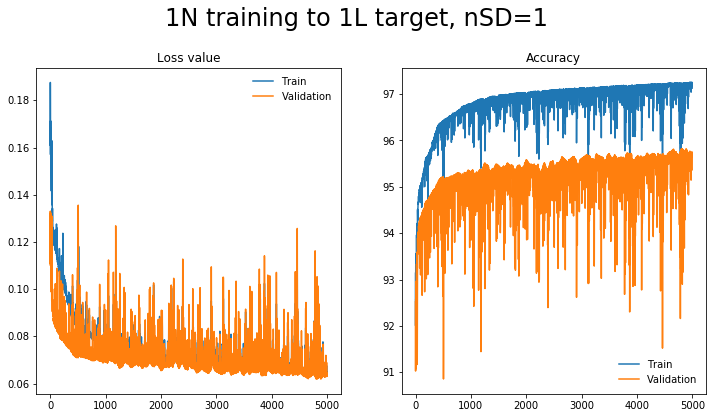

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_target), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_target), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,101)

fig.suptitle("1N training to 1L target, nSD=1 ", fontsize=24, y=1.02)
plt.show()

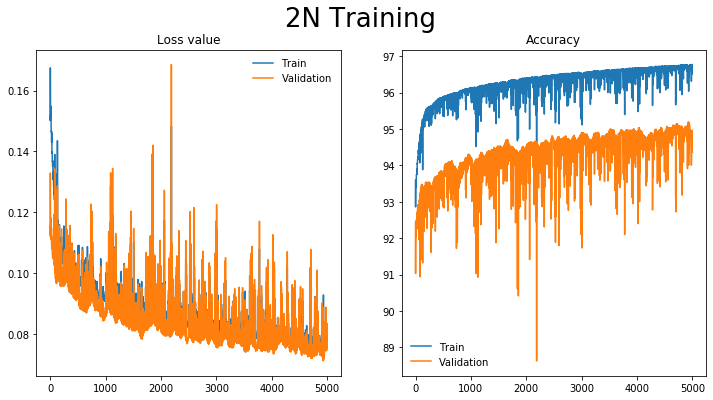

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_target), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_target), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

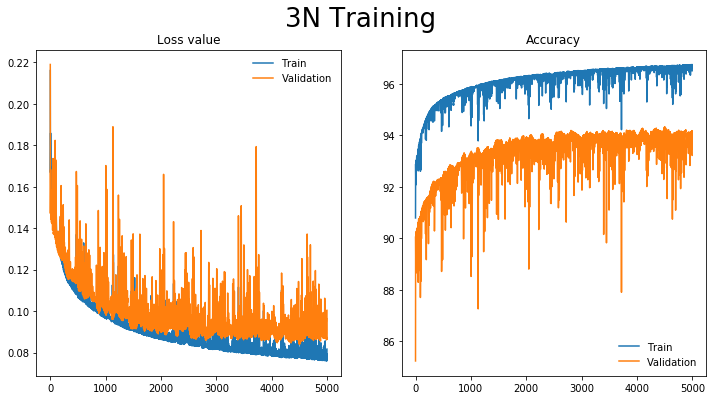

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_target), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_target), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

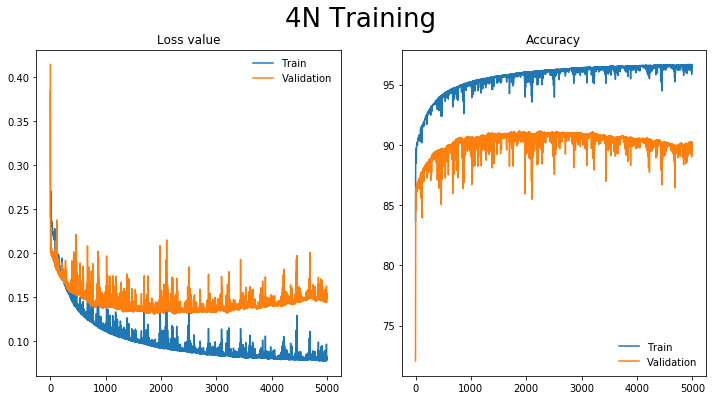

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_target), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_target), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

## Validate fit function ran with tied parameters only and variable training iterations: results here

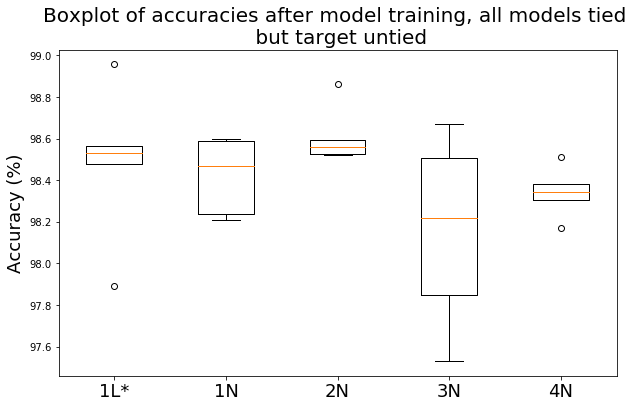

In [158]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_valtied), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_valtied), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n all models tied but target untied', fontsize=20)
ax.boxplot(test_accs_arr)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])


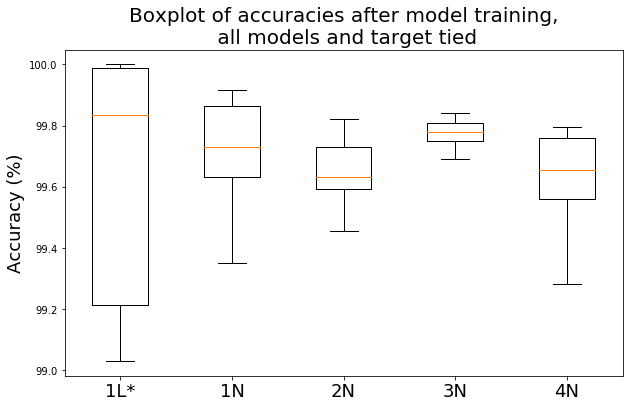

In [260]:
train_accs_arrt = np.squeeze(np.clip(np.array(train_accs_list_valtiedt), a_min=0, a_max=None))
test_accs_arrt = np.squeeze(np.clip(np.array(test_accs_list_valtiedt), a_min=0, a_max=None))

train_accst = np.array(train_accs_arrt, ndmin=2)
test_accst = np.array(test_accs_arrt, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training,\n all models and target tied', fontsize=20)
ax.boxplot(train_accs_arrt)
# ax.boxplot(test_accs_arrt, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])


## Validate fit function then ran with tied parameters, but untied at final stage (e.g. for 3N model, tied models trained up to 3N and parameters then untied)

In [430]:
loaded_models = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/val_tu_1n4.npz', allow_pickle=True)
target_params_list, trained_params_list, inputs = loaded_models['a'], \
loaded_models['b'], loaded_models['c']

In [431]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [432]:
# first we need to extract metrics from both tied and untied models - useful to see what happens after untying e.g.
# do we overfit straight away
# reload parameters, create models with them and extract accuracy metrics

train_accs_list_tun4=[]
test_accs_list_tun4=[]

for j in range(len(target_params_list)):
    params_1l = trained_params_list[j][0]
    params_1n = trained_params_list[j][1]
    params_2n = trained_params_list[j][2]
    params_3n = trained_params_list[j][3]
    params_4n = trained_params_list[j][4]

    hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
    for i in range(len(hln_1l.params)):
        hln_1l.params[i].assign(params_1l[i])

    hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
    for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])

    hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
    for i in range(len(hln_2n.params)):
        hln_2n.params[i].assign(params_2n[i])

    hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True,
                                                                             True, True, True, True]))
    for i in range(len(hln_3n.params)):
        hln_3n.params[i].assign(params_3n[i])

    hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                             True, True, True, True, True, True, True,
                                                                             True]))
    for i in range(len(hln_4n.params)):
        hln_4n.params[i].assign(params_4n[i])

    target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))

    for i in range(len(target_model.params)):
        target_model.params[i].assign(target_params_list[j][i])
        
        
    # generate target traces 
    train_target = target_model(train_inputs)
    val_target = target_model(val_inputs)
    test_target = target_model(test_inputs)    
        
        
    # evaluate models on test data:
    train_accs, test_accs = [], []
    models=[hln_1l, hln_1n, hln_2n, hln_3n, hln_4n]
    for model in models:
        train_out, test_out = model(train_inputs), model(test_inputs)
        train_acc = 100 * (1-loss(train_out, train_target)/np.var(train_target))
        test_acc = 100 * (1-loss(test_out, test_target)/np.var(test_target))
        train_accs.append([train_acc.numpy()])
        test_accs.append(test_acc.numpy())

    train_accs_list_tun4.append(train_accs)
    test_accs_list_tun4.append(test_accs)

In [312]:
inputs.shape

(749, 160000)

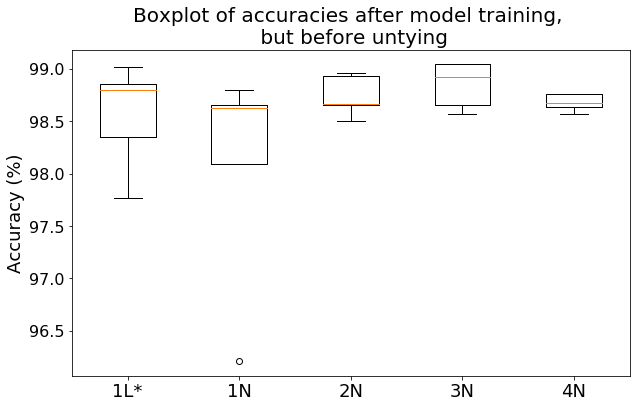

In [268]:
train_accs_arrt = np.squeeze(np.clip(np.array(train_accs_list_tied), a_min=0, a_max=None))
test_accs_arrt = np.squeeze(np.clip(np.array(test_accs_list_tied), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n but before untying', fontsize=20)
ax.boxplot(test_accs_arrt)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

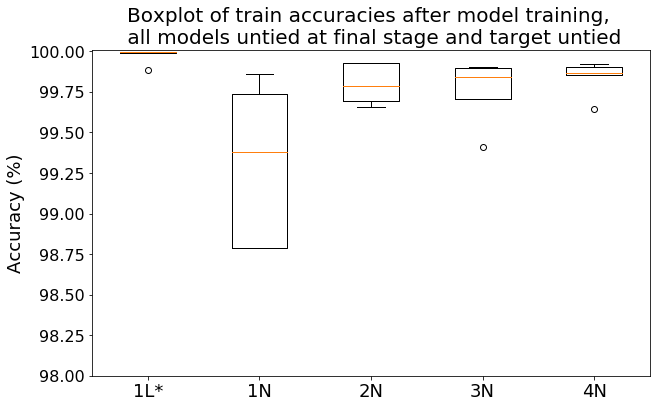

In [295]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_untied), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_untied), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models untied at final stage and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

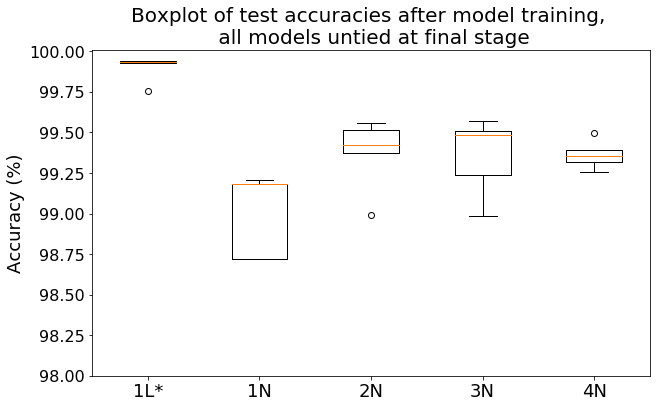

In [296]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models untied at final stage', fontsize=20)
ax.boxplot(test_accs_arr)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)
ax.tick_params(axis='y', labelsize=16)

plt.show()

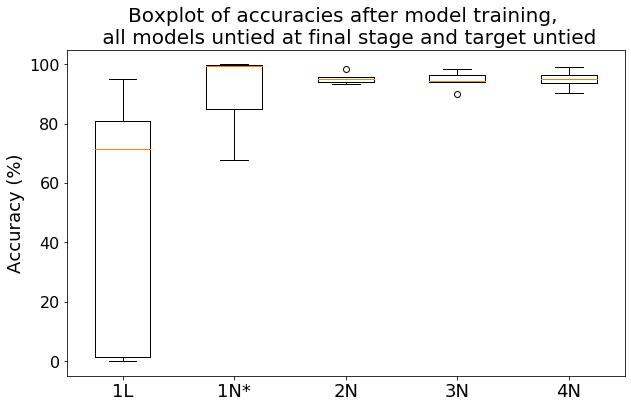

In [257]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_untiedn), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_untiedn), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n all models untied at final stage and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

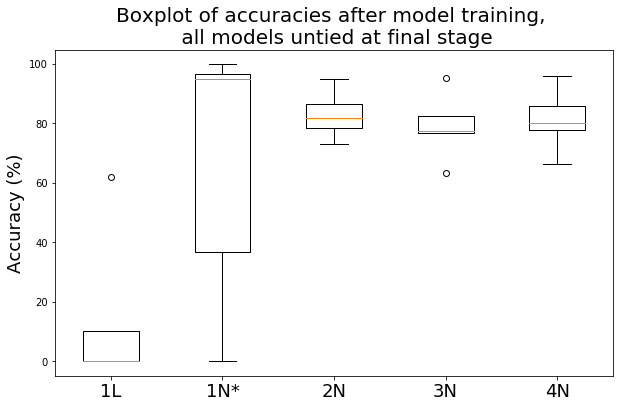

In [235]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n all models untied at final stage', fontsize=20)
ax.boxplot(test_accs_arr)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

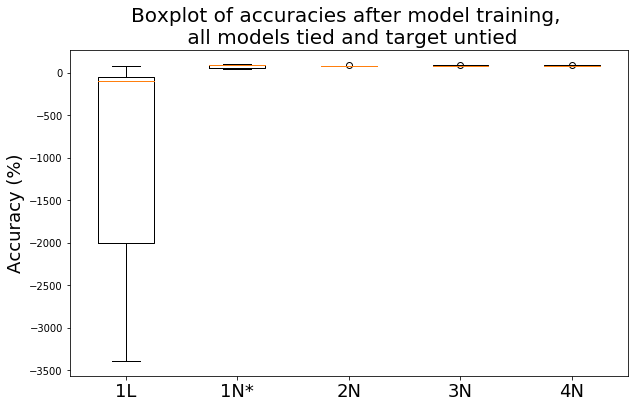

In [241]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tiedn), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tiedn), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

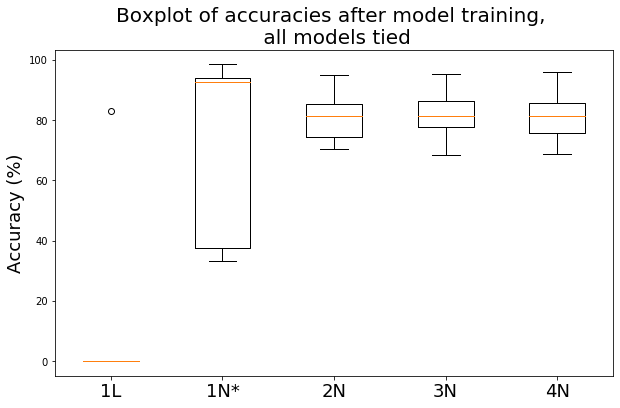

In [240]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training, \n all models tied', fontsize=20)
ax.boxplot(test_accs_arr)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## Tried doubling the data for a 1L target:

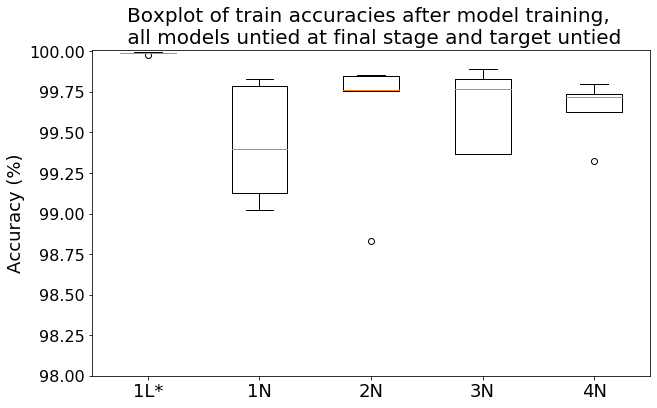

In [286]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_untied_long), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_untied_long), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models untied at final stage and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

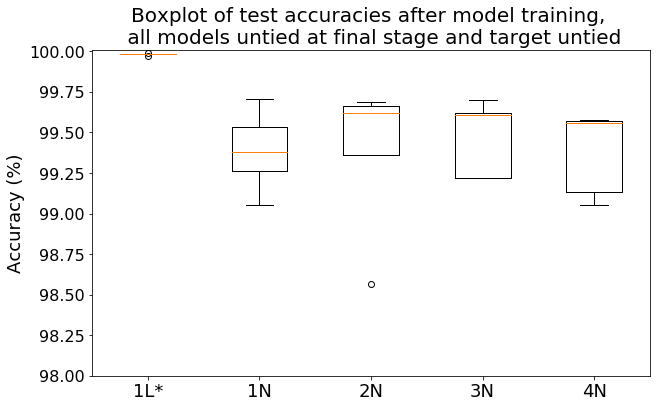

In [294]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models untied at final stage and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

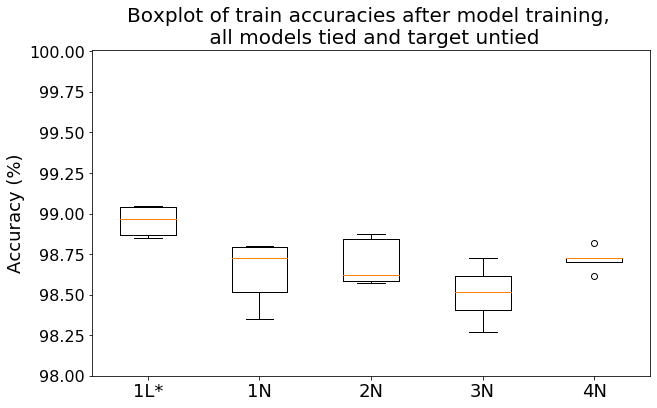

In [285]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tied_long), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tied_long), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

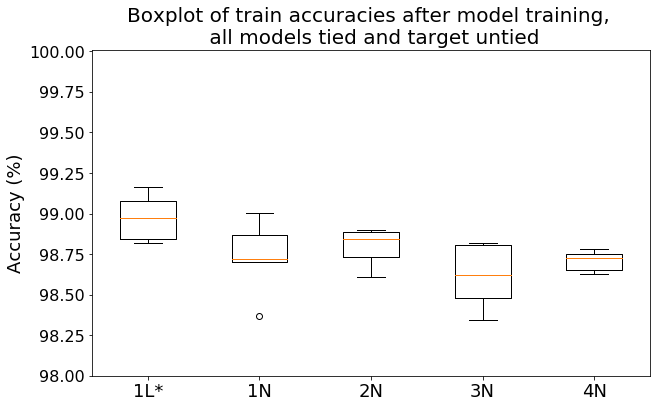

In [283]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

In [289]:
hln_1l_tied = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
hln_1l_tied(inputs)

<tf.Tensor: shape=(96000,), dtype=float32, numpy=
array([ 0.01873185,  0.01873185,  0.01873185, ..., -0.44423333,
       -0.4452209 , -0.48575744], dtype=float32)>

## Investigate 1N and 1L training only, worry about others later 

In [330]:
# first we need to extract metrics from both tied and untied models - useful to see what happens after untying e.g.
# do we overfit straight away
# reload parameters, create models with them and extract accuracy metrics

train_accs_list_ss2=[]
test_accs_list_ss2=[]

for j in range(len(target_params_list)):
    params_1l = untied_trained_params_list[j][0]
    params_1n = untied_trained_params_list[j][1]

    hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
    for i in range(len(hln_1l.params)):
        hln_1l.params[i].assign(params_1l[i])

    hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
    for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])

  
    target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

    for i in range(len(target_model.params)):
        target_model.params[i].assign(target_params_list[j][i])
        
        
    # generate target traces 
    train_target = target_model(train_inputs)
    val_target = target_model(val_inputs)
    test_target = target_model(test_inputs)    
        
        
    # evaluate models on test data:
    train_accs, test_accs = [], []
    models=[hln_1l, hln_1n]
    for model in models:
        train_out, test_out = model(train_inputs), model(test_inputs)
        train_acc = 100 * (1-loss(train_out, train_target)/np.var(train_target))
        test_acc = 100 * (1-loss(test_out, test_target)/np.var(test_target))
        train_accs.append([train_acc.numpy()])
        test_accs.append(test_acc.numpy())

    train_accs_list_ss2.append(train_accs)
    test_accs_list_ss2.append(test_accs)

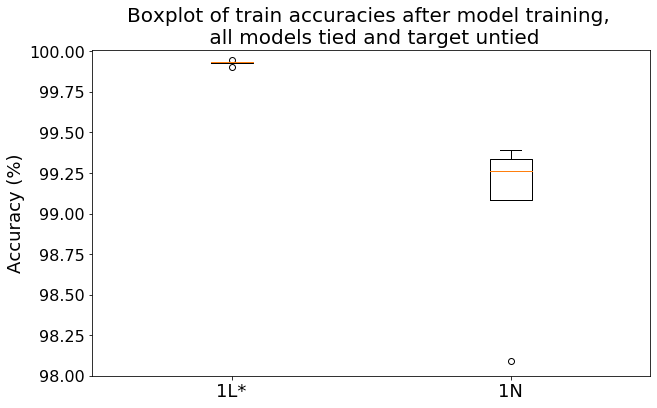

In [307]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_ss), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_ss), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

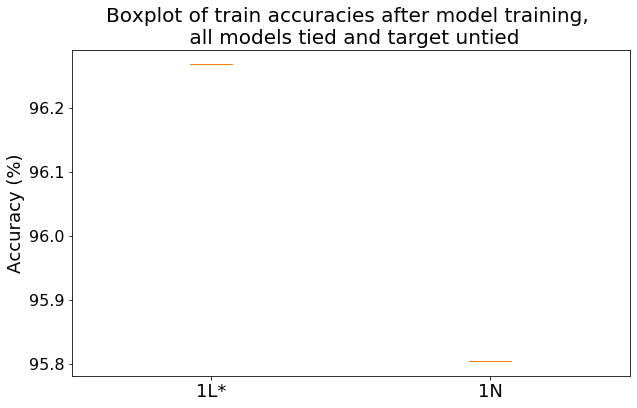

In [335]:
# try with new train_until - remembers last 2 val losses instead of last 1
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_ss2), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_ss2), a_min=0, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

### Now try lots of data option instead of tying

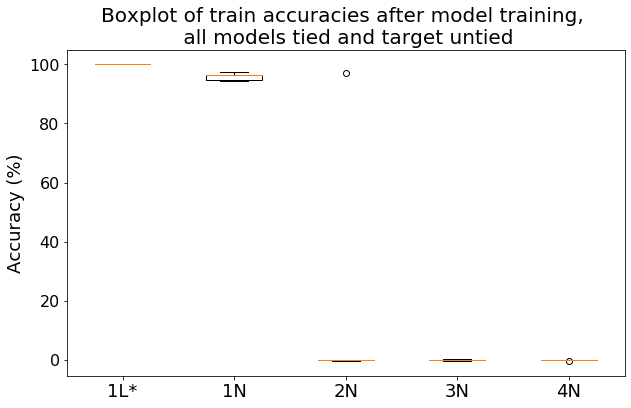

In [319]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_long), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_long), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

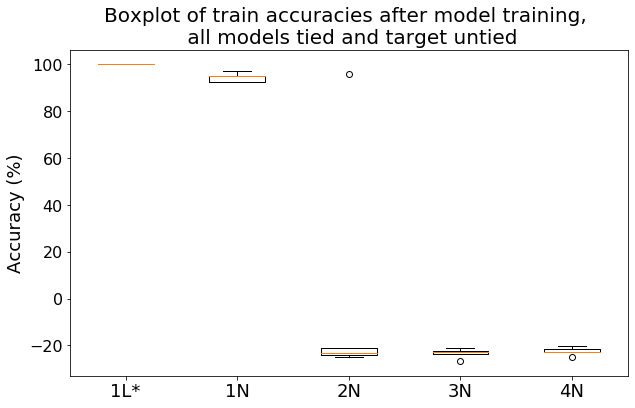

In [320]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

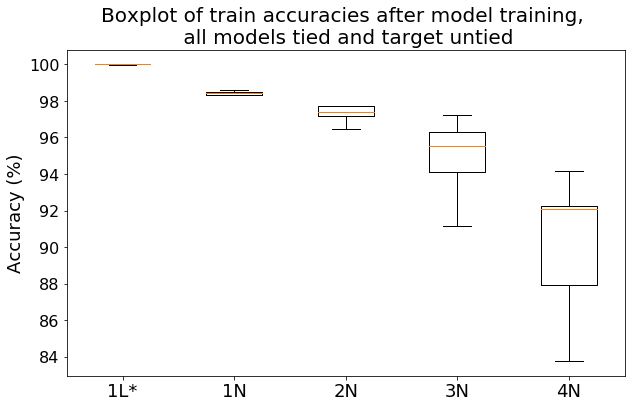

In [326]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_long2), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_long2), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

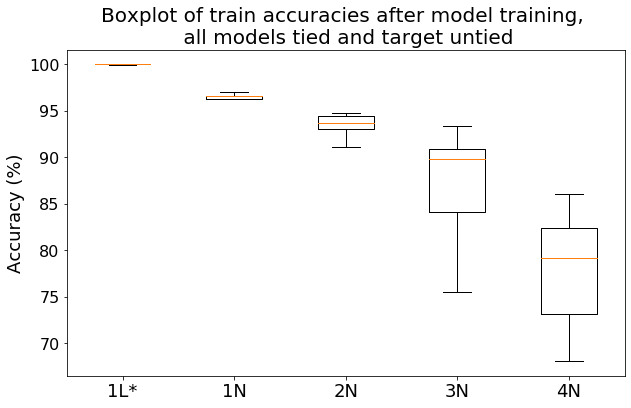

In [327]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

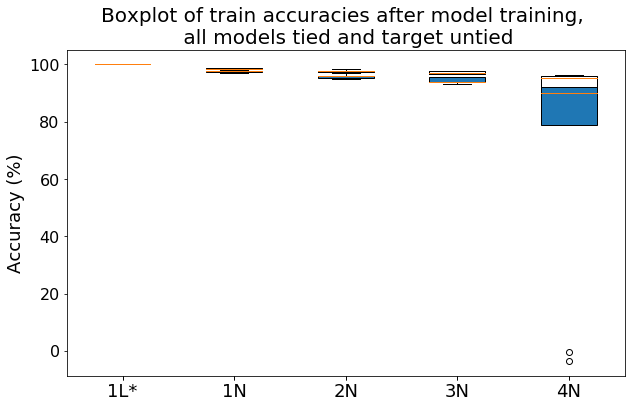

In [347]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_long3), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_long3), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

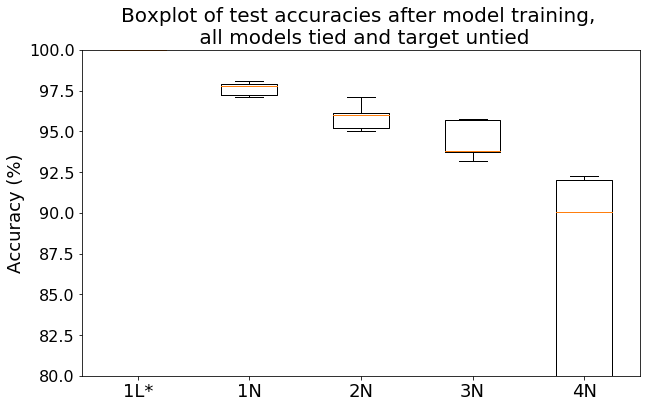

In [346]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(80,100.01)
# ax.set_ylim(100)

plt.show()

## Tried new train_until function that remembers last 2 val losses, max 50000 epochs, nSD=1 only

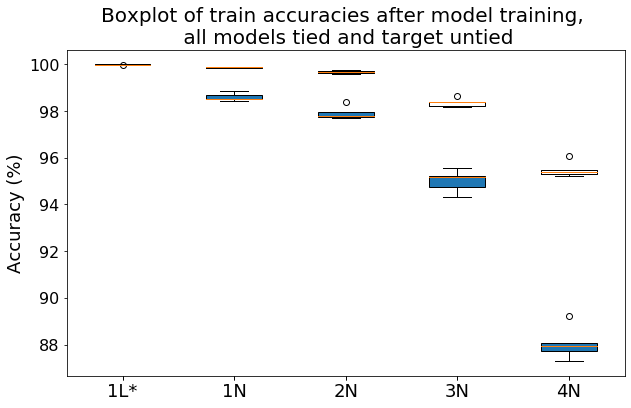

In [356]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tu), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tu), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

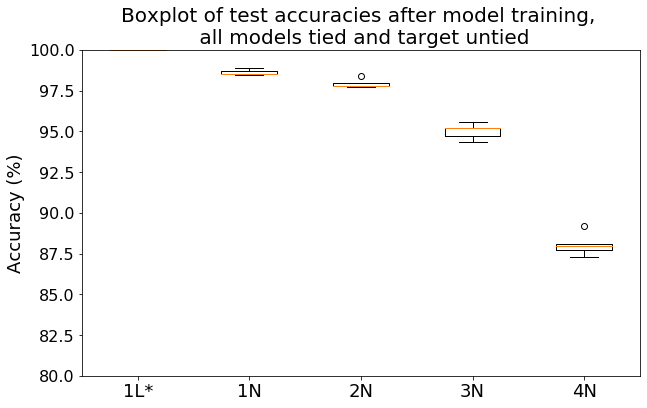

In [354]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(80,100.01)
# ax.set_ylim(100)

plt.show()

## Tried new train_until function that remembers last 2 val losses, max 10000 epochs, nSD=[1,2,4], tied procedures not used

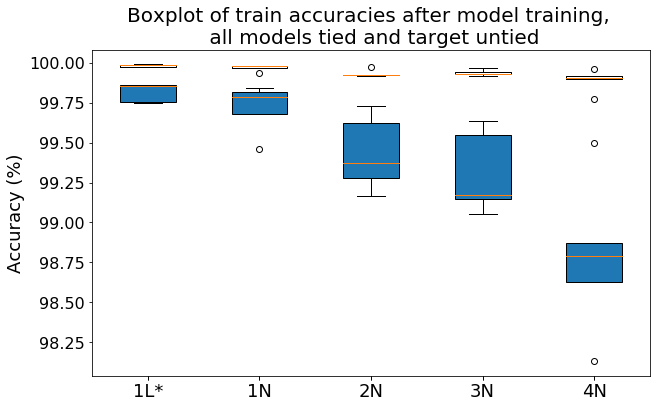

In [383]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tu2), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tu2), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

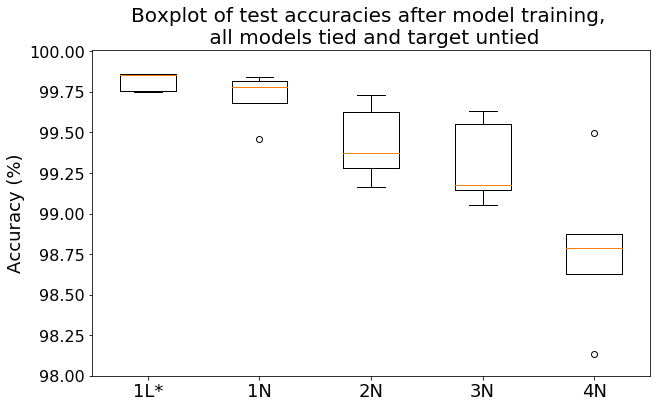

In [384]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## Try with higher range of nsds - if we get closer initially, then can we get there without so many training epochs

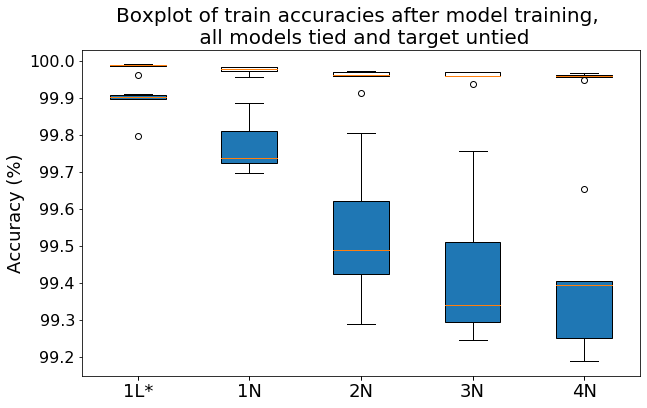

In [393]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tu3), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tu3), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

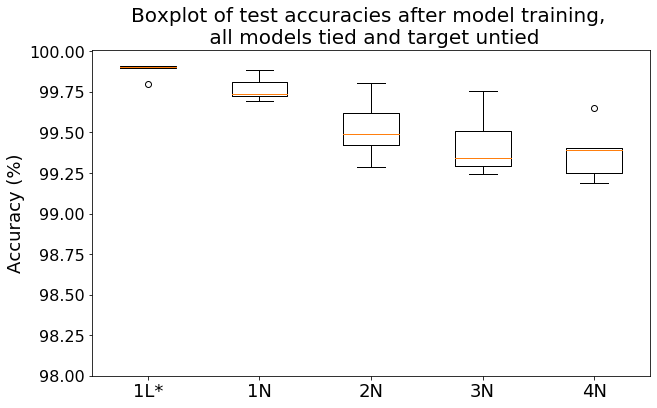

In [371]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## Try higher range of nsds still

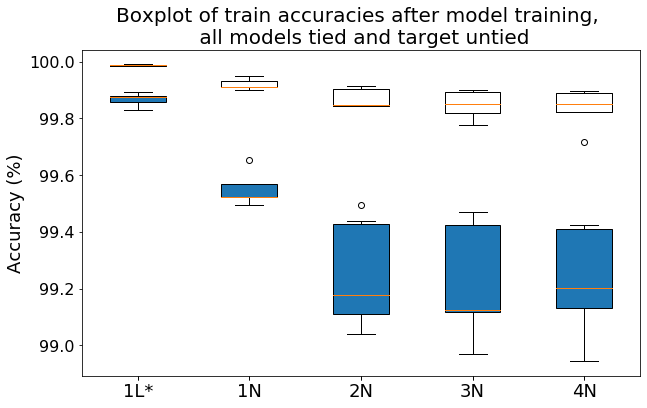

In [378]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tu4), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tu4), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

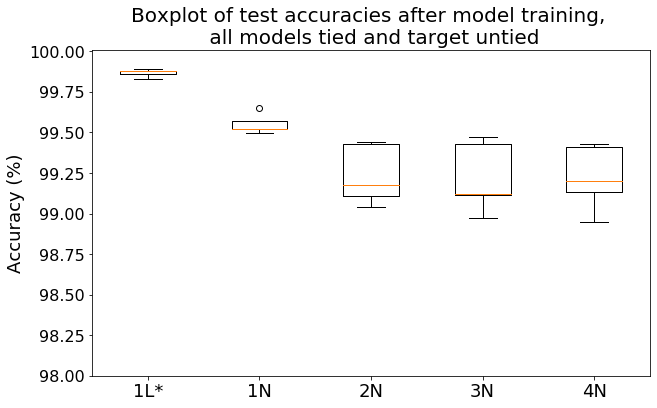

In [377]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of test accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(test_accs_arr)
# ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## Increased max epochs to 20000 as max_epochs never exceeded previously

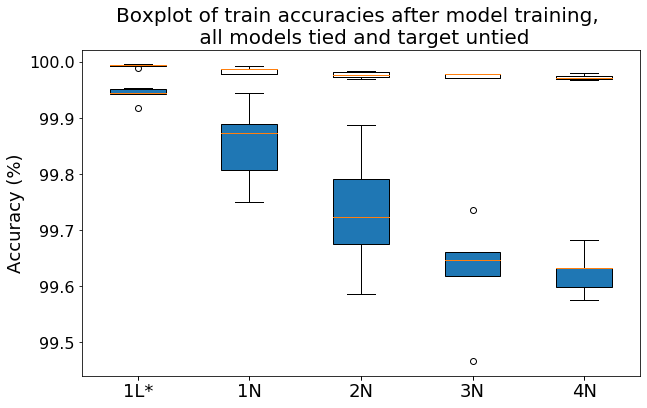

In [401]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tu5), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tu5), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## Same experiment parameters, 1N target

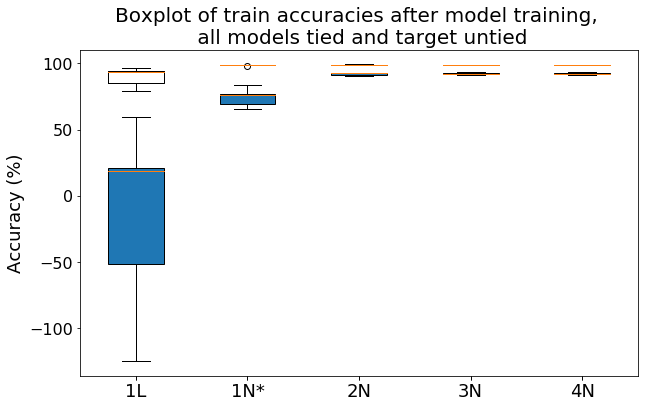

In [420]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tun), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tun), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## 1N target again, but double amount of data to hopefully improve test accs

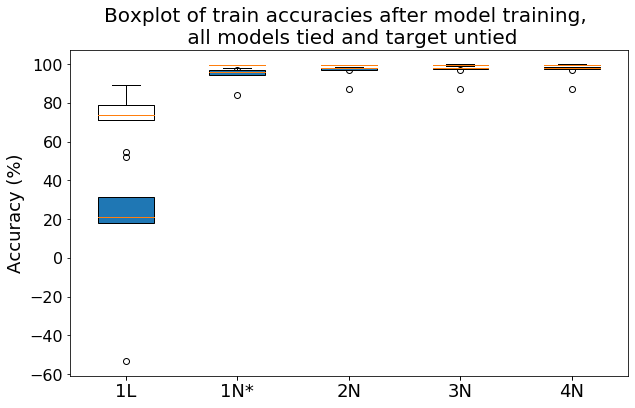

In [422]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tun2), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tun2), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()

## 1N target again, but only 1.6s of data so we should be able to overfit

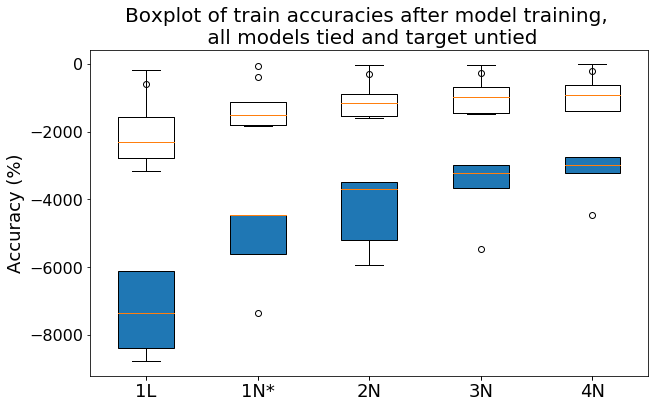

In [434]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list_tun4), a_min=-10000, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list_tun4), a_min=-10000, a_max=None))

train_accs = np.array(train_accs_arr, ndmin=2)
test_accs = np.array(test_accs_arr, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of train accuracies after model training, \n all models tied and target untied', fontsize=20)
ax.boxplot(train_accs_arr)
ax.boxplot(test_accs_arr, patch_artist=True)
ax.set_xticklabels(['1L', '1N*', '2N', '3N', '4N'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(98,100.01)
# ax.set_ylim(100)

plt.show()